<a href="https://colab.research.google.com/github/nitish-raj/Kaggle/blob/main/tps-july-22-soft-voting-with-sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inspired by https://www.kaggle.com/code/adaubas/tps-jul22-lgbm-extratree-qda-soft-voting/notebook, following notebook fits classifier using Sklearn.

In [1]:
import pandas as pd
import numpy as np

import gc,os

from sklearn.preprocessing import PowerTransformer,RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.ensemble import VotingClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 

from sklearn.neural_network import MLPClassifier


import warnings
warnings.filterwarnings('ignore')

In [5]:
if 'google.colab' in str(get_ipython()):
  colab = 1
  print('Running on CoLab')
else:
  colab = 0
  print('Not running on CoLab')

Running on CoLab


In [7]:
if colab ==1 :
  from google.colab import files

  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    
  # Then move kaggle.json into the folder where the API expects to find it.
  !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [2]:
random_state = 0
n_folds = 10
n_components = 7
verbose = 500
os.environ['PYTHONHASHSEED'] = str(random_state)
np.random.seed(random_state)

In [10]:
!kaggle competitions download -c tabular-playground-series-jul-2022
!unzip tabular-playground-series-jul-2022.zip
!rm tabular-playground-series-jul-2022.zip

 97% 19.0M/19.6M [00:00<00:00, 199MB/s]
100% 19.6M/19.6M [00:00<00:00, 201MB/s]
Archive:  tabular-playground-series-jul-2022.zip
  inflating: data.csv                
  inflating: sample_submission.csv   


In [11]:
if colab == 1:
  data = pd.read_csv("/content/data.csv",index_col = 'id')
  sample_submission =pd.read_csv("/content/sample_submission.csv")
else:
  data = pd.read_csv("data.csv",index_col = 'id')
  sample_submission =pd.read_csv("sample_submission.csv")

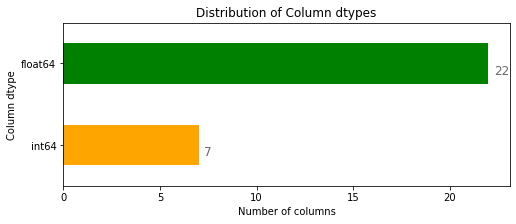

In [12]:
ax = data.dtypes.value_counts().plot.barh(color = ['green','orange'],rot = 0,figsize = (8,3))
ax.set_title('Distribution of Column dtypes')
ax.set_xlabel('Number of columns')
ax.set_ylabel('Column dtype')

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, str(i.get_width()), fontsize=12,
color='dimgrey')
    
ax.invert_yaxis()

In [13]:
# Using PowerTransformer before Scaling to adjust for Outliers
data_scaled = pd.DataFrame(PowerTransformer().fit_transform(data),columns=data.columns)
#data_scaled = pd.DataFrame(RobustScaler().fit_transform(data_scaled), columns=data_scaled.columns)

#www.kaggle.com/competitions/tabular-playground-series-jul-2022/discussion/334808
useful_cols  = ['f_07','f_08', 'f_09', 'f_10','f_11', 'f_12', 'f_13', 'f_22','f_23', 'f_24', 'f_25','f_26','f_27', 'f_28']

# Test Data for predictions later
test_data = data_scaled[useful_cols].copy()

In [14]:
# Fit Bayesian Gaussian Mixture
print('Fitting Bayesian Gaussian Mixture..')
bgm = BayesianGaussianMixture(n_components = n_components,
                         max_iter = 300, n_init = 10, 
                     random_state = random_state,
                 verbose = 1,
             verbose_interval = 100
                     )

bgm_labels = bgm.fit_predict(data_scaled[useful_cols])
bgm_proba = bgm.predict_proba(data_scaled[useful_cols])

Fitting Bayesian Gaussian Mixture..
Initialization 0
  Iteration 100
Initialization converged: True
Initialization 1
Initialization converged: True
Initialization 2
Initialization converged: True
Initialization 3
  Iteration 100
Initialization converged: True
Initialization 4
  Iteration 100
  Iteration 200
Initialization converged: True
Initialization 5
  Iteration 100
  Iteration 200
Initialization converged: True
Initialization 6
Initialization converged: True
Initialization 7
Initialization converged: True
Initialization 8
Initialization converged: True
Initialization 9
Initialization converged: True


In [15]:
#Using idea from https://www.kaggle.com/code/adaubas/tps-jul22-lgbm-extratree-qda-soft-voting

# Creating Best data based on predicted probability of BGM model

data_scaled['predict']= bgm_labels
data_scaled['predict_proba']=0

for n in range(n_components):
    data_scaled[f'bgm_proba_{n}']= bgm_proba[:,n]
    data_scaled.loc[data_scaled.predict == n,'bgm_proba']=data_scaled[f'bgm_proba_{n}']
    
train_index=np.array([])
for n in range(n_components):
    median=data_scaled[data_scaled.predict==n]['bgm_proba'].median()

    # Experiment with different thresholds
    # Higher thereshold might overfit
    n_inx=data_scaled[(data_scaled.predict==n) & (data_scaled.bgm_proba > 0.9)].index
    
    train_index = np.concatenate((train_index, n_inx))
    print(f'class:{n}',f'median: {round(median,4)}','Training data:'+str(round(len(n_inx)/len(data_scaled[(data_scaled.predict==n)]),2)*100)+'%')
    
    
print(f'\nSize of Training data : {len(train_index)}')

class:0 median: 0.9074 Training data:51.0%
class:1 median: 0.8685 Training data:44.0%
class:2 median: 0.9376 Training data:56.99999999999999%
class:3 median: 0.7311 Training data:25.0%
class:4 median: 0.8669 Training data:44.0%
class:5 median: 0.9833 Training data:73.0%
class:6 median: 0.9118 Training data:52.0%

Size of Training data : 48674


In [16]:
X=data_scaled.loc[train_index][useful_cols].to_numpy()
y=data_scaled.loc[train_index]['predict'].to_numpy()
#xtrain,xvalid, ytrain,yvalid = train_test_split(X,y,random_state = random_state,test_size = 0.2)

In [ ]:
# Define parameter for the GradientBoostingClassifier for hyperparameter tuning.
gbc_praman_grid = { 'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    'subsample' : np.linspace(0.1, 1.0, 10, endpoint=True),
'max_depth' : np.linspace(1, 15, 15, endpoint=True),
'criterion' :  ['friedman_mse', 'mse'],
'min_sample_split' : np.linspace(2, 100, 50, endpoint=True),
'min_impurity_decrease' : np.linspace(0.0, 1.0, 10, endpoint=True),
}

gbc = GradientBoostingClassifier(n_estimators = 3000,
                        random_state=random_state,
                     max_features = 'auto',
                    validation_fraction =0.2,
                    n_iter_no_change = 100,
                    verbose = 1
                    )

gbc_search = HalvingGridSearchCV(gbc,gbc_praman_grid,resource='n_estimators',
                                 max_resources=2000, random_state=random_state,cv=5,verbose= 1).fit(X,y)

In [ ]:
# Create parameter grid
parameter_grid = {'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
                  'max_depth' : np.linspace(1, 15, 15, endpoint=True),
                  'max_leaf_nodes': [10,30,35,40,45,55,60],
                  'min_samples_leaf': np.linspace(10, 100, 10, endpoint=True),
                  'l2_regularization': np.linspace(0.0, 1.0, 10, endpoint=True),
                  "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
                  }

# Create and fit classifier

hgbc = HistGradientBoostingClassifier(max_iter = 3000,
                                      random_state=random_state,
                    validation_fraction =0.2,
                    n_iter_no_change = 100,
                    verbose = 1
)

# Create grid search
# Create GridSearchCV object
hgbc_grid_search = HalvingGridSearchCV(hgbc, parameter_grid, cv=5, scoring='roc_auc',n_jobs= -1)
hgbc_grid_search.fit(X, y)


# Print results
print(hgbc_grid_search.best_score_)
print(hgbc_grid_search.best_params_)


In [17]:
gc.collect()
# XG Boost can also be used
gbc = GradientBoostingClassifier(n_estimators = 3000,
                        subsample = 0.6,
                        random_state=random_state,
                     max_features = 'auto',
                    validation_fraction =0.2,
                    n_iter_no_change = 200,
                    max_depth = 12,
                    verbose = 1
                    )

# This is inspired by LGBM. LGBM can also be used directly
hgbc = HistGradientBoostingClassifier(max_iter = 5000,
                                      learning_rate = 0.06,
                                      random_state=random_state,
                    validation_fraction =0.2,
                    n_iter_no_change = 200,
                    l2_regularization=0.1,
                    verbose = 1
)

# Saving time by using ML classifier. Can experiment with Torch/Keras based NN models as well
mlpc = MLPClassifier(learning_rate = 'adaptive',
                    max_iter = 5000,
                    hidden_layer_sizes = (400,200,100,),
                    early_stopping = True,
                    n_iter_no_change = 200,
                    validation_fraction = 0.2,
                    )

qda = QuadraticDiscriminantAnalysis()

gpc = GaussianProcessClassifier(max_iter_predict=1000, random_state  =random_state)

# This is simplified version of soft voting as suggested by 
# https://www.kaggle.com/code/pourchot/simple-soft-voting?scriptVersionId=100462375&cellId=6
vcsft = VotingClassifier(estimators=[('GBC', gbc), ('HGBC', hgbc),('MLPC',mlpc),('QDA',qda),('GPC',gpc)], 
                 voting='soft',verbose=verbose)

In [ ]:
vcsft.fit(X,y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3578           0.4696          113.91m
         2           1.0824           0.2615          122.66m
         3           0.8828           0.1863          125.62m
         4           0.7309           0.1403          126.90m
         5           0.6116           0.1097          128.06m
         6           0.5143           0.0884          128.63m
         7           0.4357           0.0724          128.74m
         8           0.3685           0.0595          129.03m
         9           0.3147           0.0499          129.35m
        10           0.2684           0.0411          129.40m
        20           0.0609           0.0079          129.42m
        30           0.0160           0.0017          128.74m
        40           0.0049           0.0004          127.70m
        50           0.0017           0.0001          126.75m
        60           0.0006           0.0000          126.02m
       

In [ ]:
Predicted = vcsft.predict(test_data.to_numpy())

In [ ]:
sample_submission['Predicted']= Predicted
sample_submission.to_csv("submission.csv",index=False)
sample_submission.head()

,Id,Predicted
0,0,4
1,1,6
2,2,4
3,3,2
4,4,3


In [ ]:
!kaggle competitions submit -c tabular-playground-series-jul-2022 -f submission.csv -m "Soft Voting using Sklearn part 2"

100%|█████████████████████████████████████████| 755k/755k [00:01<00:00, 521kB/s]
Successfully submitted to Tabular Playground Series - Jul 2022